In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import copy
from scipy import stats
import statistics

In [2]:
OWNER_NAME = "Mariia Turchina"
PASSWORD = "bridport20"
Z_THRESHOLD = 2.5

In [3]:
class EntryDivider:
    """
    Separates and cleans each entry from person's dataset
    """
    
    def __init__(self, df):
        self.df = df
        self.nr_entries = self.df["entry"].max() + 1
        self.entries = self.divide_entries()
        
    def divide_entries(self):
        """
        Separates each entry from person's dataset
        """
        entries = []
        for entry_i in range(self.nr_entries):
            curr_entry = self.df[self.df["entry"] == entry_i]
            curr_entry = self.reset_time(curr_entry.sort_values(by = ["time"]).reset_index(drop = True))
            entries.append(curr_entry)
            
        return entries
    
    def reset_time(self, entry_df):
        """
        Resets times of the entry to their relative times
        """
        start_time = entry_df["time"].min()
        entry_df["time"] -= start_time
        
        return entry_df

In [4]:
class OutlierHandler:
    """
    Detects and removes outliers from a specific person
    """
    
    def __init__(self, entries): #[DataFrame]
        self.original_entries = entries
        self.clean_entries = self.handle_outliers()

    
    def handle_outliers(self):
        entries = copy.deepcopy(self.original_entries)
        keypress_times, keyrelease_times = self._get_events_dicts()
        
        z_keypress_times = self._get_z_scores(keypress_times)
        z_keyrelease_times = self._get_z_scores(keyrelease_times)
        
        for entry_i in range(len(entries)):
            entries[entry_i] = entries[entry_i].sort_values(by = ["key_char", "time"]).reset_index(drop = True)
            
            for event_i in range(0, len(entries[entry_i])-1, 2):
                curr_key_char = entries[entry_i].iloc[event_i]["key_char"]
                key = self._key_index(event_i // 2, curr_key_char)
                
                if (abs(z_keypress_times[key][entry_i]) > Z_THRESHOLD):
                    entries[entry_i].loc[event_i, "time"] = statistics.mean(keypress_times[key])
                if (abs(z_keyrelease_times[key][entry_i]) > Z_THRESHOLD):
                    entries[entry_i].loc[event_i+1, "time"] = statistics.mean(keyrelease_times[key])
                
        return entries        
        
        
    def _get_events_dicts(self):
        entries = copy.deepcopy(self.original_entries)
        keypress_times = {}
        keyrelease_times = {}
        
        sorted_password = ''.join(sorted(PASSWORD))
        for i in range(len(PASSWORD)):
            key = self._key_index(i, sorted_password[i])
            keypress_times[key] = []
            keyrelease_times[key] = []
        
        for entry_i in range(len(entries)):
            curr_entry = entries[entry_i].sort_values(by = ["key_char", "time"]).reset_index(drop = True)
            
            if (len(entries[entry_i]) % 2 != 0):
                print("we've got uneven pressing/releasing for some reason \n")
                return
            
            for event_i in range(0, len(entries[entry_i])-1, 2):
                curr_key_char = curr_entry.iloc[event_i]["key_char"]
                key = self._key_index(event_i // 2, curr_key_char)

                keypress_times[key] += [curr_entry.iloc[event_i]["time"]]
                keyrelease_times[key] += [curr_entry.iloc[event_i+1]["time"]]
        
        return keypress_times, keyrelease_times
    
    
    def _key_index(self, index, char):
        return str(index) + ": " + char
    
    
    def _get_z_scores(self, arr_dict):
        z_dict = {}
        for key, arr in arr_dict.items():
            z_dict[key] = stats.zscore(arr)
            
        return z_dict  

In [5]:
class Entry:
    """
    Provides information about each entry (its data and whether it's owner's)
    """
    
    def __init__(self, name, entry):
        self.is_owner = name == OWNER_NAME
        self.data = entry

In [6]:
class EntriesData:
    """
    Holds all the entry datas together
    """
    
    def __init__(self, entries: [Entry]):
        self.entries = entries
        
        
    def overview_plot_event_times(self, event):
        """
        Plots an event of each key of each key of entry of each individual
        """
        fig, ax = plt.subplots(figsize = (15, 15))
        xval = 0
        temp_entries = self.entries
        
        for key_char in PASSWORD:
            times = []
            for i in range(len(temp_entries)):
                entry = temp_entries[i].data
                time = entry[(entry["key_char"] == key_char) & (entry["event"] == event)]["time"].iloc[0]
                temp_entries[i].data = entry[entry["time"] != time]
                times.append(time)
                
            ax.scatter(np.linspace(xval, xval, len(times)), times)
            xval += 1
        
        ax.set_title("{}'s of each key of entry of each individual".format(event))
        locs, labels = plt.xticks() 
        plt.xticks(np.arange(len(PASSWORD)), [c for c in PASSWORD])
        
        
    def owner_event_distribution(self, event):
        """
        Plots density plot for the times of an event of each key
        """
        owner_entries = self._get_owner()
        
        fig, ax = plt.subplots(nrows = len(PASSWORD), figsize = (15, 6 * len(PASSWORD)))
        plt.subplots_adjust(hspace = 0.2)
        plt.suptitle("Distribution on owner's {}'s'".format(event))
        
        row = 0
        for key_char in PASSWORD:
            
            times = []
            for i in range(len(owner_entries)):
                entry = owner_entries[i].data
                time = entry[(entry["key_char"] == key_char) & (entry["event"] == event)]["time"].iloc[0]
                owner_entries[i].data = entry[entry["time"] != time]
                times.append(time)
                
            sns.distplot(times, ax = ax[row])
            ax[row].set_title(key_char, color = "red")
            row += 1
    
    
    def owner_presstime_distribution(self):
        """
        Plots density plot for the pressing times of each key
        """
        owner_entries = self._get_owner()
        
        fig, ax = plt.subplots(nrows = len(PASSWORD), figsize = (15, 6 * len(PASSWORD)))
        plt.subplots_adjust(hspace = 0.2)
        plt.suptitle("Distribution on owner's time of pressing each key")
        
        elapsed_times = {}
        sorted_password = ''.join(sorted(PASSWORD))
        for i in range(len(PASSWORD)):
            elapsed_times[self._key_index(i, sorted_password[i])] = [] 
        
        for entry_i in range(len(owner_entries)):
            curr_entry = owner_entries[entry_i].data.sort_values(by = ["key_char", "time"]).reset_index(drop = True)

            if (len(owner_entries[entry_i].data) % 2 != 0):
                print("we've got uneven pressing/releasing for some reason \n")
                return
            
            i = 0
            for event_i in range(0, len(owner_entries[entry_i].data)-1, 2):
                elapsed_time = curr_entry.iloc[event_i+1]["time"] - curr_entry.iloc[event_i]["time"]
                curr_key_char = curr_entry.iloc[event_i]["key_char"]
                elapsed_times[self._key_index(i, curr_key_char)] += [elapsed_time]
                i += 1
        
        row = 0
        for key, press_times in elapsed_times.items():
            sns.distplot(press_times, ax = ax[row])
            ax[row].set_title(key, color = "red")
            row += 1
                    
            
    def _get_owner(self):
        copy_entries = copy.deepcopy(self.entries)
        return [entry for entry in copy_entries if (entry.is_owner)]
                
            
    def _key_index(self, index, char):
        return str(index) + ": " + char
        
        
            

In [7]:
names = []
names.append("Mariia Turchina")
names.append("Sander Steeghs")
names.append("Finn Devlin")

def generate_entries():
    """
    Generating entries from all datasets
    """
    all_entries = []
    
    for name in names:
        name_entries = EntryDivider(pd.read_excel(name + ".xlsx", encoding = "utf8")).entries
        
        #TODO:: delete outliers
        name_entries = OutlierHandler(name_entries).clean_entries
        
        #TODO:: transform skewed
        
        for name_entry in name_entries:
            entry = Entry(name, name_entry)
            all_entries.append(entry)
            
    return all_entries

In [8]:
entries_data = EntriesData(generate_entries())

/Users/mariiaturchina/opt/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:2419: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


/Users/mariiaturchina/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/mariiaturchina/opt/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


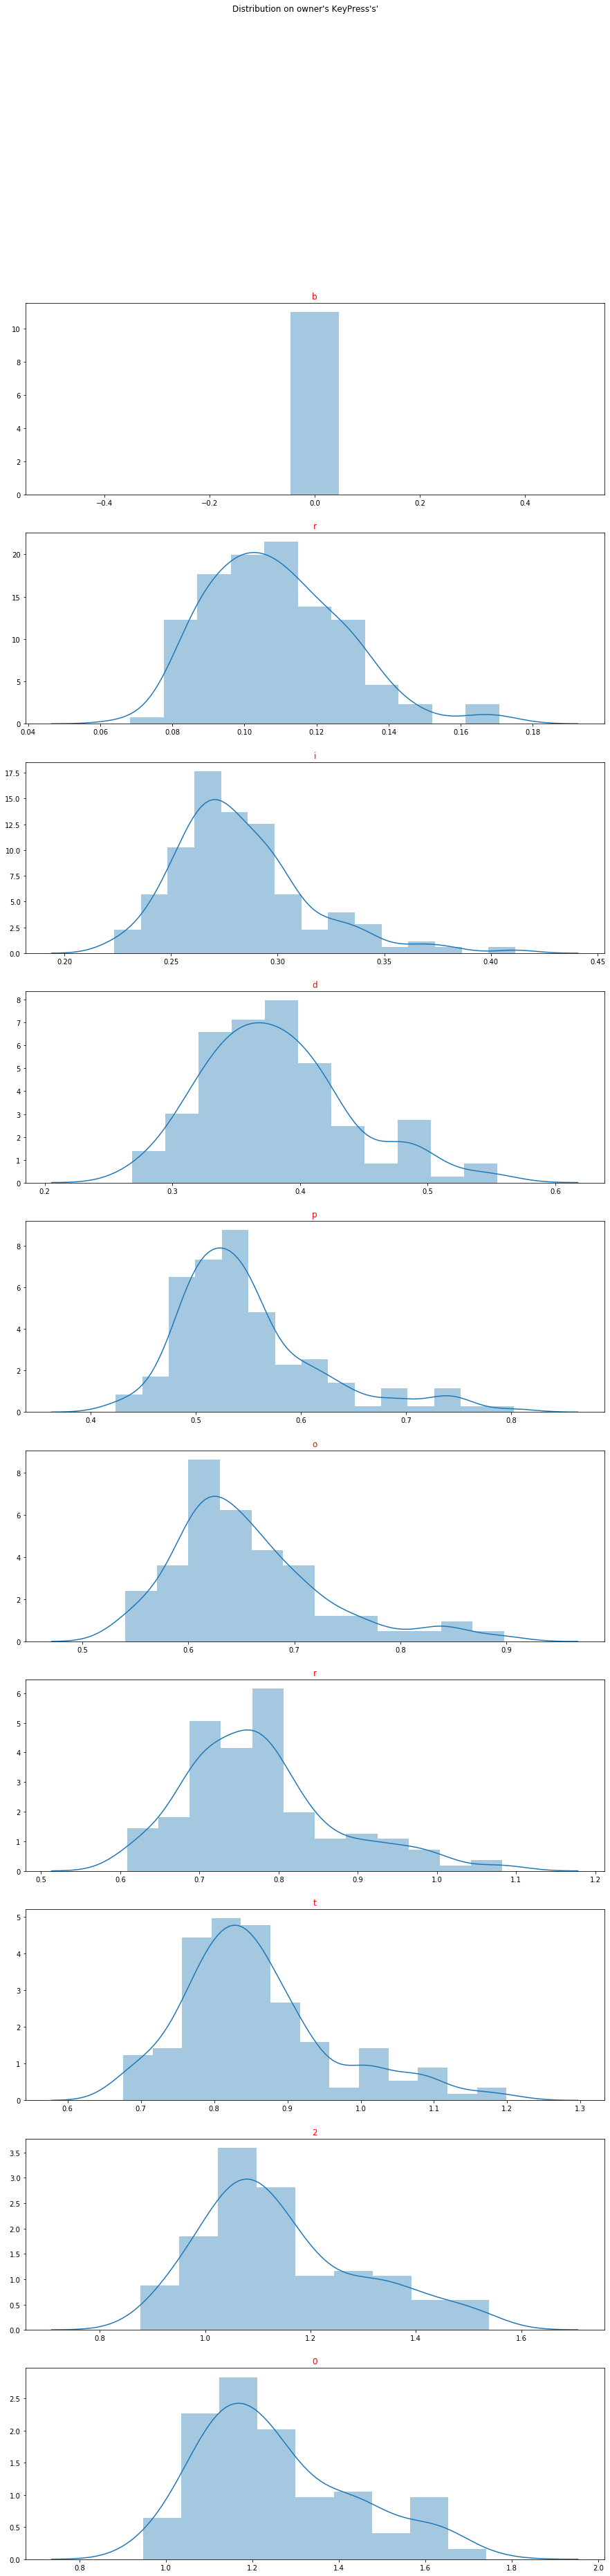

In [9]:
entries_data.owner_event_distribution("KeyPress")

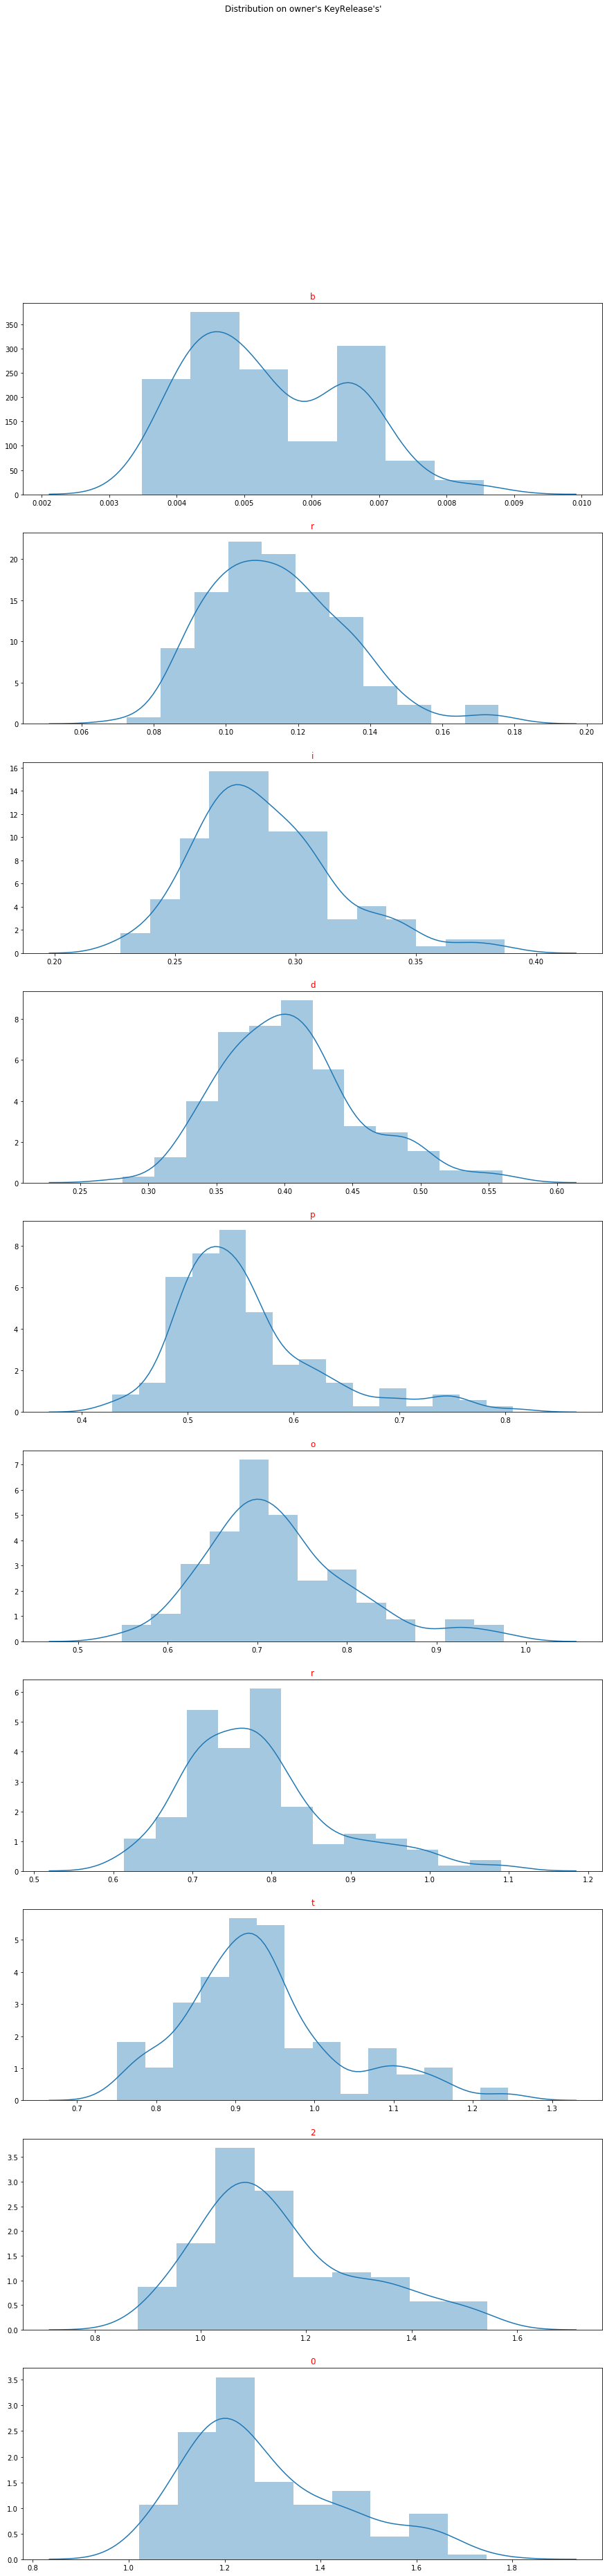

In [10]:
entries_data.owner_event_distribution("KeyRelease")

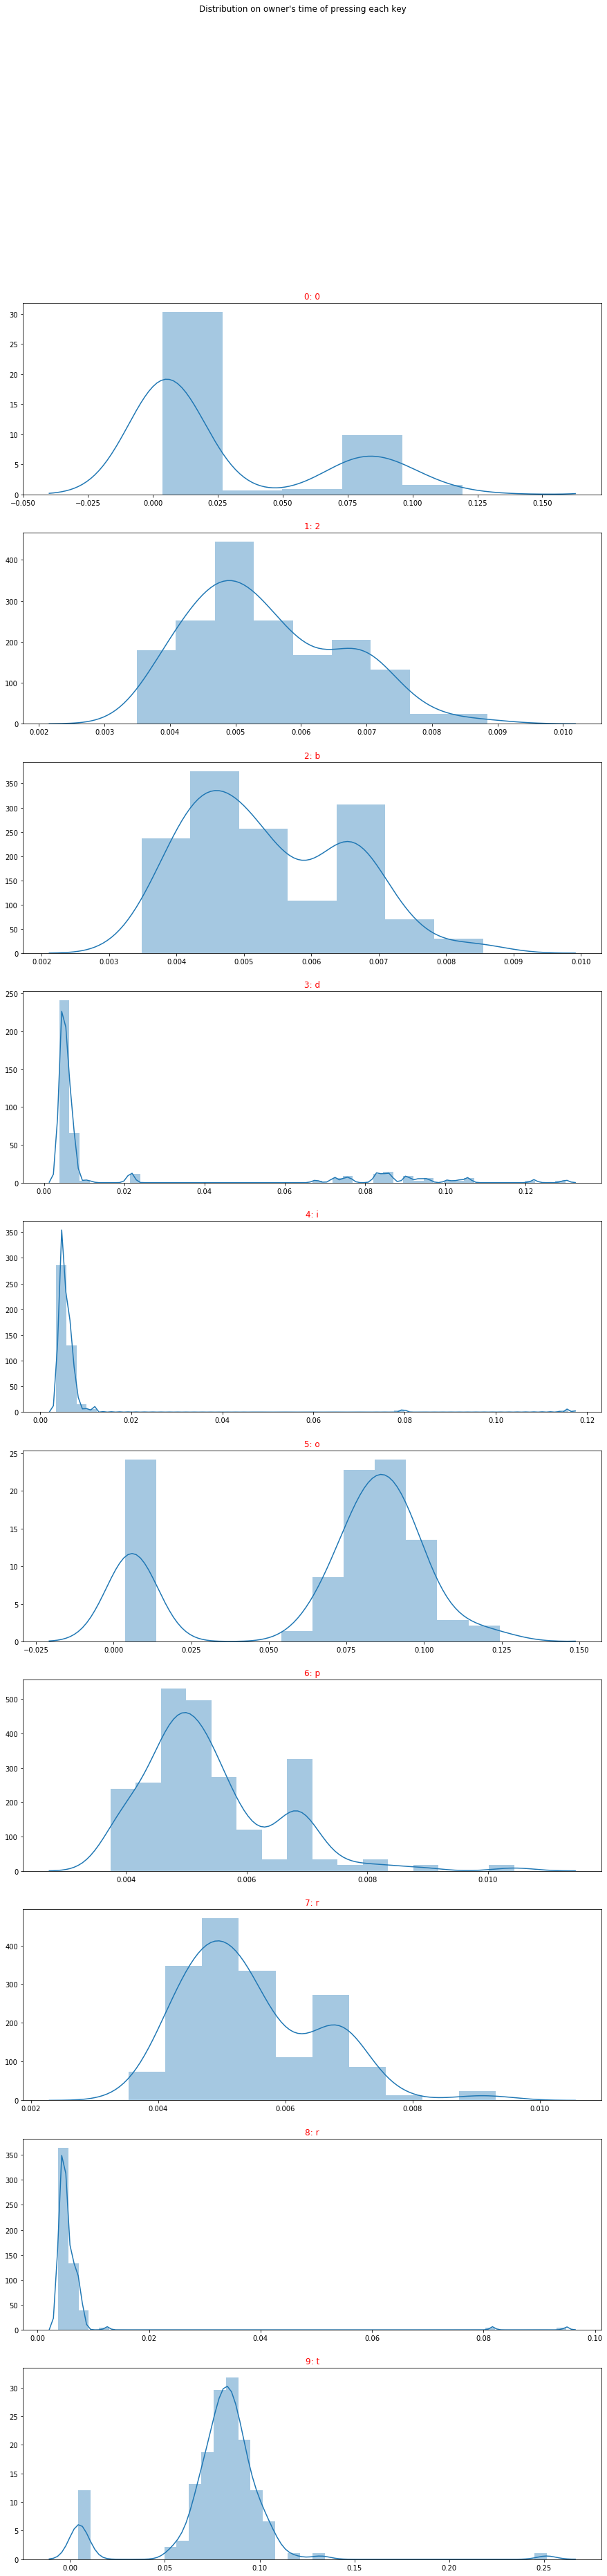

In [11]:
entries_data.owner_presstime_distribution()